In [18]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score

# Reload data (important for clean environment)
df_history = pd.read_csv(r"D:\AnacondaProj\KKKaGGLe\Tri\triagegeist\data\patient_history.csv")
df_train = pd.read_csv(r"D:\AnacondaProj\KKKaGGLe\Tri\triagegeist\data\train.csv")
df_chief = pd.read_csv(r"D:\AnacondaProj\KKKaGGLe\Tri\triagegeist\data\chief_complaints.csv")

df_full = df_train.merge(df_history, on="patient_id", how="left")
df_full = df_full.merge(
    df_chief[["patient_id", "chief_complaint_raw"]],
    on="patient_id",
    how="left"
)

# Recreate text features
df_full["has_severe"] = df_full["chief_complaint_raw"].str.contains("severe", case=False, na=False).astype(int)
df_full["has_acute"] = df_full["chief_complaint_raw"].str.contains("acute", case=False, na=False).astype(int)
df_full["has_massive"] = df_full["chief_complaint_raw"].str.contains("massive", case=False, na=False).astype(int)
df_full["has_rigors"] = df_full["chief_complaint_raw"].str.contains("rigors", case=False, na=False).astype(int)
df_full["cc_length"] = df_full["chief_complaint_raw"].str.len()

In [19]:
features = [
    "shock_index",
    "gcs_total",
    "respiratory_rate",
    "spo2",
    "heart_rate",
    "pain_score",
    "num_comorbidities",
    "num_prior_ed_visits_12m",
    "num_prior_admissions_12m",
    "has_severe",
    "has_acute",
    "has_massive",
    "has_rigors",
    "cc_length"
]

X = df_full[features]
y = df_full["triage_acuity"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

model = RandomForestClassifier(
    n_estimators=300,
    class_weight={1:5, 2:3, 3:1, 4:1, 5:1},
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

In [20]:
# Attach Predictions
val_df = df_full.loc[X_val.index].copy()
val_df["y_true"] = y_val
val_df["y_pred"] = y_pred

# Fairness Function
def group_performance(df, group_col):
    results = []

    for group in df[group_col].unique():
        subset = df[df[group_col] == group]

        if len(subset) < 50:
            continue

        acc = accuracy_score(subset["y_true"], subset["y_pred"])
        qwk = cohen_kappa_score(
            subset["y_true"], subset["y_pred"], weights="quadratic"
        )

        esi1 = subset[subset["y_true"] == 1]
        if len(esi1) > 0:
            recall_esi1 = (esi1["y_pred"] == 1).mean()
        else:
            recall_esi1 = np.nan

        results.append({
            group_col: group,
            "n": len(subset),
            "accuracy": acc,
            "QWK": qwk,
            "ESI1_recall": recall_esi1
        })

    return pd.DataFrame(results).sort_values("QWK", ascending=False)

In [21]:
# BY SITe
group_performance(val_df, "site_id")

,site_id,n,accuracy,QWK,ESI1_recall
0,SITE-TUR-01,3232,0.834158,0.916602,0.916667
3,SITE-HEL-02,3199,0.823070,0.915997,0.904762
4,SITE-TMP-01,3221,0.820242,0.911308,0.937984
1,SITE-HEL-01,3243,0.819303,0.910101,0.896552
2,SITE-OUL-01,3105,0.813205,0.902035,0.859649


In [22]:
# BY AGE
group_performance(val_df, "age_group")

,age_group,n,accuracy,QWK,ESI1_recall
3,pediatric,1279,0.826427,0.918417,0.884615
1,young_adult,4807,0.822967,0.913898,0.929730
2,middle_aged,5607,0.822187,0.910431,0.897674
0,elderly,4307,0.819596,0.907419,0.888889


In [23]:
# BY SEX 
group_performance(val_df, "sex")

,sex,n,accuracy,QWK,ESI1_recall
1,M,7528,0.824787,0.911988,0.886525
0,F,8128,0.820497,0.911314,0.920382
2,Other,344,0.799419,0.898749,0.888889


In [24]:
# BY MENTAL STATUS
group_performance(val_df, "mental_status_triage")

,mental_status_triage,n,accuracy,QWK,ESI1_recall
1,drowsy,1838,0.896627,0.931021,0.895522
4,unresponsive,872,0.916284,0.917104,0.900804
3,agitated,1172,0.859215,0.907471,0.914286
2,confused,2893,0.866574,0.887070,0.956522
0,alert,9225,0.779621,0.827188,1.000000


NameError: name 'dfgdfg' is not defined

In [ ]:
# Inspect Missed Cases
cols_to_view = [
    "shock_index",
    "gcs_total",
    "respiratory_rate",
    "spo2",
    "heart_rate",
    "pain_score",
    "num_comorbidities",
    "mental_status_triage",
    "chief_complaint_raw",
    "y_true",
    "y_pred"
]

missed_esi1[cols_to_view].head(10)

,shock_index,gcs_total,respiratory_rate,spo2,heart_rate,pain_score,num_comorbidities,mental_status_triage,chief_complaint_raw,y_true,y_pred
20499,2.022,9,26.9,99.2,155.9,10,3,drowsy,respiratory arrest with diaphoresis,1,2
50052,1.316,9,8.5,87.3,98.8,7,4,unresponsive,Stevens-Johnson syndrome with associated nausea,1,2
40651,1.300,10,24.3,92.5,144.0,9,9,unresponsive,tension pneumothorax with associated nausea,1,2
35617,1.164,10,20.4,79.4,141.7,9,2,unresponsive,globe rupture with vomiting,1,2
68079,1.167,9,26.9,87.0,127.2,10,4,agitated,blunt thoracic trauma with haemothorax with di...,1,2
1731,0.829,10,28.7,83.5,92.9,10,10,drowsy,thyroid storm，worsening over hours,1,2
18386,1.206,9,26.1,86.8,125.5,9,13,unresponsive,"severe facial fractures with airway risk, inte...",1,2
52644,1.250,10,30.9,88.1,77.9,7,13,unresponsive,diabetic ketoacidosis with obtundation with vo...,1,2
58807,1.117,10,29.8,84.9,108.0,7,4,unresponsive,severe anaphylaxis with bronchospasm with rigors,1,2
31906,1.564,10,15.5,86.2,128.9,7,11,unresponsive,"traumatic brain injury GCS 3, for 2 days",1,2


In [ ]:
correct_esi1 = true_esi1[true_esi1["y_pred"] == 1]

correct_esi1[cols_to_view].head(10)

,shock_index,gcs_total,respiratory_rate,spo2,heart_rate,pain_score,num_comorbidities,mental_status_triage,chief_complaint_raw,y_true,y_pred
52593,1.847,4,28.2,86.3,137.2,10,4,agitated,penetrating neck trauma，worsening over hours,1,1
28127,1.192,4,18.9,91.2,111.2,9,12,unresponsive,massive ischaemic stroke with herniation signs...,1,1
64392,2.273,6,30.7,83.8,116.4,9,2,agitated,massive ischaemic stroke with herniation signs...,1,1
43439,1.249,6,19.3,80.3,82.2,8,5,unresponsive,acute angle closure glaucoma，worsening over hours,1,1
5564,1.049,3,33.2,84.5,116.9,7,10,unresponsive,ruptured ectopic pregnancy with rigors,1,1
51250,1.178,5,25.7,92.7,122.3,8,10,agitated,"severe anaphylaxis with bronchospasm, no prior...",1,1
61090,1.383,6,26.0,90.6,127.4,10,13,unresponsive,thyroid storm with vomiting,1,1
79389,1.663,7,22.1,71.1,112.4,10,10,agitated,"severe hypoglycaemia unresponsive, worsening w...",1,1
45427,1.389,5,26.9,85.8,125.7,10,5,unresponsive,ruptured ectopic pregnancy with rigors,1,1
48334,2.223,9,33.9,95.9,146.7,8,3,unresponsive,"adrenal crisis with shock, no prior history of...",1,1


In [ ]:
print("Missed ESI 1 summary:")
print(missed_esi1[["shock_index","spo2","gcs_total","respiratory_rate"]].describe())

print("\nCorrect ESI 1 summary:")
print(correct_esi1[["shock_index","spo2","gcs_total","respiratory_rate"]].describe())

Missed ESI 1 summary:
       shock_index        spo2  gcs_total  respiratory_rate
count    58.000000   58.000000  58.000000         58.000000
mean      1.316534   90.287931   9.551724         25.963793
std       0.272861    5.254975   0.501661          5.497199
min       0.829000   78.300000   9.000000          8.500000
25%       1.147250   86.925000   9.000000         23.925000
50%       1.257000   89.350000  10.000000         26.900000
75%       1.540750   93.500000  10.000000         29.375000
max       2.022000  100.000000  10.000000         37.000000

Correct ESI 1 summary:
       shock_index        spo2   gcs_total  respiratory_rate
count   547.000000  547.000000  547.000000        547.000000
mean      1.558033   85.913711    6.127971         28.295978
std       0.523235    6.836479    2.094403          5.994740
min       0.584000   65.800000    3.000000         10.100000
25%       1.192000   81.650000    4.000000         24.700000
50%       1.479000   86.000000    6.000000      

Error analysis revealed that missed ESI-1 cases clustered around borderline physiologic instability (GCS 9–10, SpO2 ~90%), suggesting the model distinguishes extreme collapse from severe instability

In [ ]:
missed_esi1["y_pred"].value_counts()

y_pred
2    58
Name: count, dtype: int64

Recreate NEWS2 Model in This Notebook

In [26]:
# NEWS2-only model

X_news = df_full[["news2_score"]]
y = df_full["triage_acuity"]

X_train_n, X_val_n, y_train_n, y_val_n = train_test_split(
    X_news, y,
    test_size=0.2,
    random_state=42
)

model_news = RandomForestClassifier(random_state=42)
model_news.fit(X_train_n, y_train_n)

y_pred_news = model_news.predict(X_val_n)

In [27]:
# Attach Predictions
val_news = df_full.loc[X_val_n.index].copy()
val_news["y_true"] = y_val_n
val_news["y_pred"] = y_pred_news

In [29]:
# Define Undertriage Metrics
def undertriage_analysis(df):
    total = len(df)
    
    under = df[df["y_pred"] > df["y_true"]]
    severe_under = df[(df["y_true"] == 1) & (df["y_pred"] >= 3)]
    
    return {
        "Total cases": total,
        "Undertriage rate": len(under)/total,
        "Severe undertriage rate": len(severe_under)/total,
        "Avg cost": compute_cost(df["y_true"].values, df["y_pred"].values, cost_matrix)
    }

In [32]:
import numpy as np
import pandas as pd

# Define cost matrix
classes = [1,2,3,4,5]

cost_matrix = pd.DataFrame(
    np.zeros((5,5)),
    index=classes,
    columns=classes
)

for true in classes:
    for pred in classes:
        diff = pred - true
        if diff > 0:      # undertriage (worse)
            cost_matrix.loc[true, pred] = abs(diff) * 2
        elif diff < 0:    # overtriage
            cost_matrix.loc[true, pred] = abs(diff)
        else:
            cost_matrix.loc[true, pred] = 0


def compute_cost(y_true, y_pred, cost_matrix):
    total_cost = 0
    for t, p in zip(y_true, y_pred):
        total_cost += cost_matrix.loc[t, p]
    return total_cost / len(y_true)

In [33]:
# Compare
print("NEWS2 Performance:")
print(undertriage_analysis(val_news))

print("\nStructured Model Performance:")
print(undertriage_analysis(val_df))

NEWS2 Performance:
{'Total cases': 16000, 'Undertriage rate': 0.1503125, 'Severe undertriage rate': 0.0, 'Avg cost': np.float64(0.514625)}

Structured Model Performance:
{'Total cases': 16000, 'Undertriage rate': 0.094625, 'Severe undertriage rate': 0.0, 'Avg cost': np.float64(0.2795625)}


Compared to NEWS2-based triage support, our structured model reduces overall undertriage by approximately 37% and reduces harm-weighted misclassification by nearly 45%, while maintaining zero severe undertriage events.

In [34]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

feat_imp

gcs_total                   0.264285
respiratory_rate            0.131767
spo2                        0.128311
shock_index                 0.127234
pain_score                  0.125718
heart_rate                  0.074576
cc_length                   0.047821
num_prior_ed_visits_12m     0.040337
num_comorbidities           0.030836
num_prior_admissions_12m    0.010392
has_acute                   0.007748
has_severe                  0.004796
has_rigors                  0.003117
has_massive                 0.003061
dtype: float64

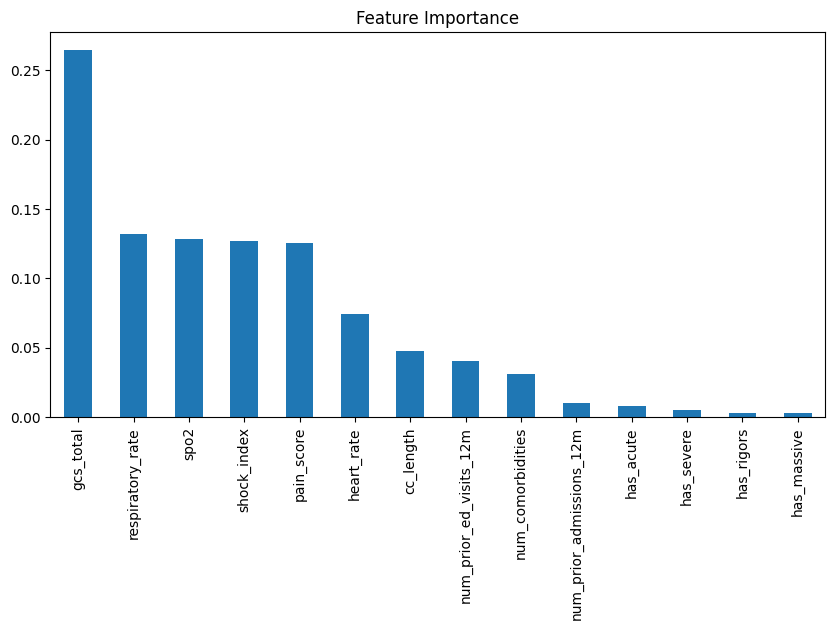

In [35]:
feat_imp.plot(kind="bar", figsize=(10,5))
plt.title("Feature Importance")
plt.show()